In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1
Torchvision Version:  0.2.2


In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(torch.cuda.get_device_name(0))

cuda:0
GeForce RTX 2080 Ti


In [3]:
runs_list = next(os.walk('../Data/Images'))[1]

In [4]:
path = "../Data/Labels.csv"
header = ['Run','AD']
Labelsdf = pd.read_csv(path, names=header, usecols=[1,2], skiprows=1, index_col=False)

In [5]:
labels_dict = dict(zip(Labelsdf.Run, Labelsdf.AD))

In [ ]:
import re

# BASELINE RGB
img_dir = "../Data/Images"
low_bound = 100
high_bound = 200
img_scale = 1
depth_scale = 33

imgs, labels = [], []

for run in runs_list:
    run_dir = os.path.join(img_dir, run)
    run_imgs = []
    print(run_dir)
    for filename in os.listdir(run_dir):
        img_num = int(filename[-7:-4])
        if (100 <= img_num < 199):
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            img_slice = img_slice/256
            run_imgs.append(img_slice)

    temp_arr = np.array(run_imgs)
    
    if temp_arr.size == 0 or temp_arr.shape[1] != 256 or temp_arr.shape[2] != 176:
        continue

    # add black bars on the left/right
    temp_imgs = []
    for img_slice in temp_arr:
        final_slice = np.zeros([256,256])
        final_slice[:, 40:216] = img_slice
        temp_imgs.append(final_slice)
    
    temp_arr = np.array(temp_imgs)
    
    final_slices = []
    
    for y in range(temp_arr.shape[2]):
        xz_pane = temp_arr[:, :, y]
        scaled_xz = cv2.resize(xz_pane, (0, 0), fy=1/depth_scale, fx=1, interpolation=cv2.INTER_AREA)
        final_slices.append(scaled_xz)
    
    if not len(final_slices[0]) == 3:
        continue
    
    final_array = np.dstack(final_slices)
    # Doesn't exist in labels
    if run in labels_dict:
        imgs.append(final_array)
        labels.append(labels_dict[run])

imgs = np.array(imgs)
labels = np.array(labels)

In [69]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [70]:
ad_imgs, ad_labels = [], []

for idx, ad in np.ndenumerate(labels):
    if ad:
        ad_imgs.append(imgs[idx])
        ad_labels.append(1)

ad_imgs = np.array(ad_imgs)
ad_labels = np.array(ad_labels)

normal_ratio = imgs.shape[0] // ad_imgs.shape[0]

new_imgs = np.concatenate((imgs, np.repeat(ad_imgs, normal_ratio, axis=0)), axis=0)
new_labels = np.concatenate((labels, np.repeat(ad_labels, normal_ratio, axis=0)), axis=0)

# new_imgs = imgs
# new_labels = labels

In [71]:
class T1Dataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [72]:
full_dataset = T1Dataset(new_imgs, new_labels)
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

In [73]:
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size,
                                                   pin_memory=True,
                                                   shuffle=True, num_workers=0) for x in ['train', 'val', 'test']}

In [74]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [75]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [76]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 256

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 256

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 256

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\xieji/.torch\models\densenet121-a639ec97.pth
32342954it [00:00, 60269938.97it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

)


In [77]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [78]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.6419 Acc: 0.6244
val Loss: 0.5805 Acc: 0.7188

Epoch 1/14
----------
train Loss: 0.5566 Acc: 0.7177
val Loss: 0.5717 Acc: 0.6756

Epoch 2/14
----------
train Loss: 0.5295 Acc: 0.7508
val Loss: 0.5390 Acc: 0.7211

Epoch 3/14
----------
train Loss: 0.5155 Acc: 0.7543
val Loss: 0.5284 Acc: 0.7701

Epoch 4/14
----------
train Loss: 0.4803 Acc: 0.7862
val Loss: 0.5042 Acc: 0.7713

Epoch 5/14
----------
train Loss: 0.4737 Acc: 0.7842
val Loss: 0.5894 Acc: 0.6791

Epoch 6/14
----------
train Loss: 0.4669 Acc: 0.7912
val Loss: 0.4840 Acc: 0.7806

Epoch 7/14
----------
train Loss: 0.4407 Acc: 0.8060
val Loss: 0.4793 Acc: 0.7713

Epoch 8/14
----------
train Loss: 0.4375 Acc: 0.8118
val Loss: 0.4690 Acc: 0.7958

Epoch 9/14
----------
train Loss: 0.4236 Acc: 0.8149
val Loss: 0.4656 Acc: 0.7760

Epoch 10/14
----------
train Loss: 0.4143 Acc: 0.8289
val Loss: 0.4574 Acc: 0.7865

Epoch 11/14
----------
train Loss: 0.4033 Acc: 0.8344
val Loss: 0.4599 Acc: 0.7830

Ep

Epoch 0/14
----------
train Loss: 0.6664 Acc: 0.6120
val Loss: 0.6239 Acc: 0.6826

Epoch 1/14
----------
train Loss: 0.6042 Acc: 0.6956
val Loss: 0.5833 Acc: 0.7106

Epoch 2/14
----------
train Loss: 0.5556 Acc: 0.7321
val Loss: 0.5306 Acc: 0.7468

Epoch 3/14
----------
train Loss: 0.5027 Acc: 0.7636
val Loss: 0.7873 Acc: 0.5741

Epoch 4/14
----------
train Loss: 0.4446 Acc: 0.8033
val Loss: 0.4372 Acc: 0.8121

Epoch 5/14
----------
train Loss: 0.3327 Acc: 0.8779
val Loss: 0.3472 Acc: 0.8576

Epoch 6/14
----------
train Loss: 0.2795 Acc: 0.9024
val Loss: 0.4456 Acc: 0.7760

Epoch 7/14
----------
train Loss: 0.1825 Acc: 0.9456
val Loss: 0.3139 Acc: 0.8471

Epoch 8/14
----------
train Loss: 0.1059 Acc: 0.9728
val Loss: 0.2550 Acc: 0.8996

Epoch 9/14
----------
train Loss: 0.1453 Acc: 0.9452
val Loss: 3.9238 Acc: 0.4481

Epoch 10/14
----------
train Loss: 0.1090 Acc: 0.9650
val Loss: 1.0207 Acc: 0.6278

Epoch 11/14
----------
train Loss: 0.0962 Acc: 0.9689
val Loss: 0.5073 Acc: 0.8016

Ep

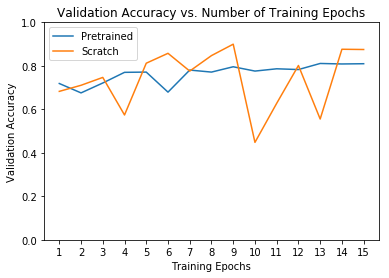

In [79]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()